# PCA on Marcellus Groundwater Dissolved Gas Concentrations

This notebook details the computation of Principal Components of the Marcellus groundwater study <http://www.pnas.org/content/111/39/14076.abstract>. The study measured a variety of dissolved gases, and chloride concentrations, in an effort to distinguish natural methane migration into shallow groundwater from leakage from faulty wells. The dissolved components measured were: Methane, Ethane, N$_2$, O$_2$, Argon, $^3$He,  $^4$He, $^{20}$Ne,  $^{36}$Ar, and the dissolved solid Cl$^-$. We first load the raw data:

In [59]:
%pylab inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Mar=pd.read_csv('MarcelData.csv')
col=Mar.columns

Populating the interactive namespace from numpy and matplotlib


We now remove missing values and take the log$_{10}$ of all the concentration data. Missing ethane values are filled in with a quartic approximation based on the methane concentration. 

In [60]:
MethQuad=np.log10(Mar.methane)
EthQuad=np.log10(Mar.ethane)

EthQuad=EthQuad[np.isnan(MethQuad)==0]
MethQuad=MethQuad[np.isnan(MethQuad)==0]

minEth=np.nanmin(np.log10(Mar.ethane[Mar.ethane>0]))[0]
EthQuad[np.isnan(EthQuad)]=minEth
EthP=np.polyfit(MethQuad,EthQuad,4)

EthGuess=np.polyval(EthP,MethQuad)

Mar.ethane[np.isnan(Mar.ethane)]=np.polyval(EthP,np.log10(Mar.methane[np.isnan(Mar.ethane)]))
Mar.ethane[np.log10(Mar.ethane)<4]=10**3.6


We now remove the methane concentration from the data frame, in order to compute the PCA on the other variables, and determine whether they provide a predictive set of transformed variables for methane concentration. This cell also computes the correlation coefficents of the dissolved concentrations. 

In [61]:
for i in range(len(col)):
    Mar=Mar[Mar[col[i]]>0]

methData=np.log10(Mar.methane)

Mar=Mar[col[1:]]

MarAr=np.array(Mar)
MarLog=np.log10(MarAr)
MarLogP=np.log10(Mar)

C=np.corrcoef(np.transpose(MarLog))

CFrame=pd.DataFrame(C,columns=col[1:])
CFrame['Chem']=col[1:]


We now compute the eigenvectors and eigenvalues of the correlation matrix of the dissolved concentrations:

In [62]:
eVals, eVecs = np.linalg.eig(C)

eig_pairs = [(np.abs(eVals[i]), eVecs[:,i]) for i in range(len(eVals))]

Valsum=sum(eVals)
ValCum=np.cumsum(eVals/Valsum)

The following cell plots the fraction of variance present in each principal component, which is equal to each eigenvalue 

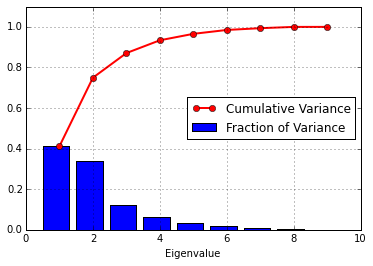

In [63]:
plt.bar(np.arange(len(eVals))+.5,eVals/Valsum,label='Fraction of Variance')
plt.plot(np.arange(len(eVals))+1,ValCum,lw=2,marker='o',label='Cumulative Variance',color='red')

plt.xlabel('Eigenvalue')
plt.legend(loc='center right')
plt.ylim([0,1.1])
plt.grid()

The following cell plots the Marcellus data in its first and second principal components. 

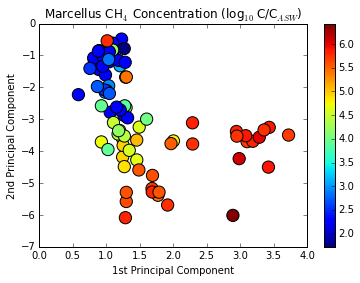

In [64]:
LenCol=len(col[1:])
matrix_w = np.hstack((eig_pairs[0][1].reshape(LenCol,1),eig_pairs[1][1].reshape(LenCol,1),eig_pairs[2][1].reshape(LenCol,1) ))
Y = MarLog.dot(matrix_w)

plt.figure()
plt.scatter(Y[:,0],Y[:,1],c=methData,s=150)
plt.colorbar()
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title('Marcellus CH$_4$ Concentration (log$_{10}$ C/C$_{ASW}$)')


The data are now scattered along the first and second principal components, in a largely orthogonal pattern. 

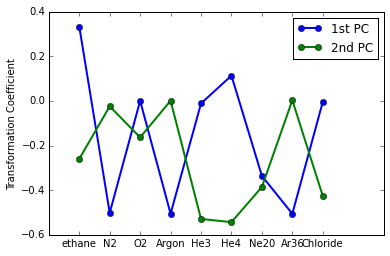

In [71]:
plt.plot(1+np.arange(len(matrix_w)),matrix_w[:,0],marker='o',lw=2,label='1st PC' );
plt.plot(1+np.arange(len(matrix_w)),matrix_w[:,1],marker='o',lw=2 ,label='2nd PC')
plt.xlim([0,11])
plt.xticks(1+np.arange(len(matrix_w)),col[1:]);
plt.legend(loc='upper right');
plt.ylabel('Transformation Coefficient');